In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize, Compose, ToTensor
from tqdm import tqdm


# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [36]:
!pip install names_generator

In [37]:
# Clean up output dir:
!rm -rf /kaggle/working/outputs

In [38]:
from names_generator import generate_name

# Reading and plotting data:

In [39]:
base_path = "/kaggle/input/2023-flame-ai-challenge/"
working_dir = "/kaggle/working/"
input_path = base_path + "dataset/"
output_path = working_dir + "outputs/"

# create directories for checkpoints and logs
log_dir = output_path + "logs/"
checkpoint_dir = output_path + "ckpt/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

train_df = pd.read_csv(input_path + "train.csv")
val_df = pd.read_csv(input_path + "val.csv")
test_df = pd.read_csv(input_path + "test.csv")

In [40]:
# print 5 rows of pandas dataframe
train_df.head()

,id,dx_m,rho_filename,ux_filename,uy_filename,uz_filename
0,-5634614311666768042,0.000041,RHO_kgm-3_id-5634614311666768042.dat,UX_ms-1_id-5634614311666768042.dat,UY_ms-1_id-5634614311666768042.dat,UZ_ms-1_id-5634614311666768042.dat
1,-2337253536160728058,0.000041,RHO_kgm-3_id-2337253536160728058.dat,UX_ms-1_id-2337253536160728058.dat,UY_ms-1_id-2337253536160728058.dat,UZ_ms-1_id-2337253536160728058.dat
2,-7056668419406715714,0.000041,RHO_kgm-3_id-7056668419406715714.dat,UX_ms-1_id-7056668419406715714.dat,UY_ms-1_id-7056668419406715714.dat,UZ_ms-1_id-7056668419406715714.dat
3,-9138984573931233156,0.000041,RHO_kgm-3_id-9138984573931233156.dat,UX_ms-1_id-9138984573931233156.dat,UY_ms-1_id-9138984573931233156.dat,UZ_ms-1_id-9138984573931233156.dat
4,2699082921033192879,0.000041,RHO_kgm-3_id2699082921033192879.dat,UX_ms-1_id2699082921033192879.dat,UY_ms-1_id2699082921033192879.dat,UZ_ms-1_id2699082921033192879.dat


Index:825


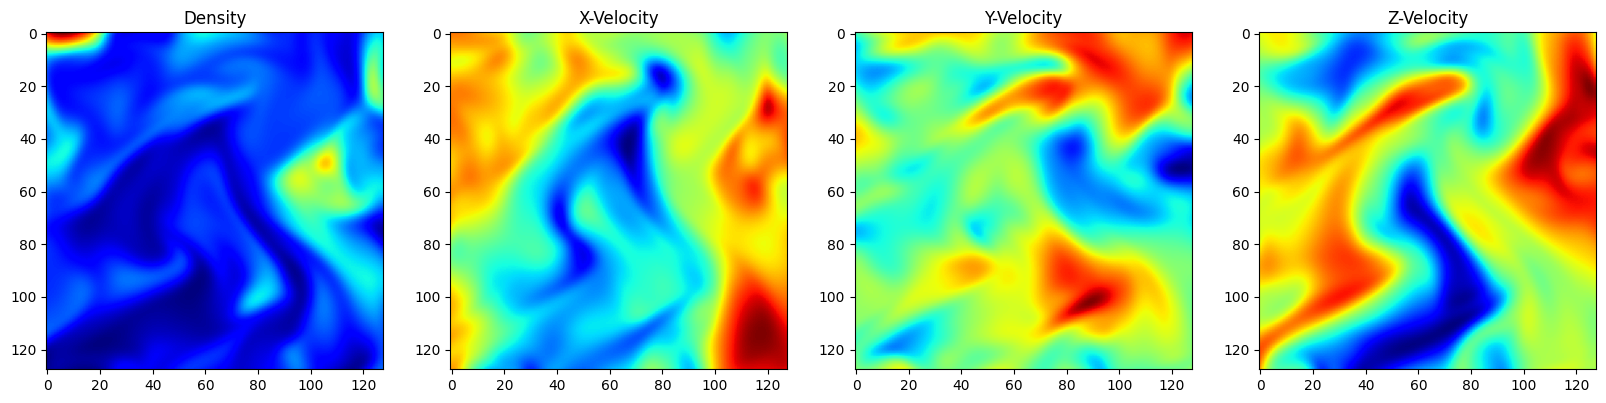

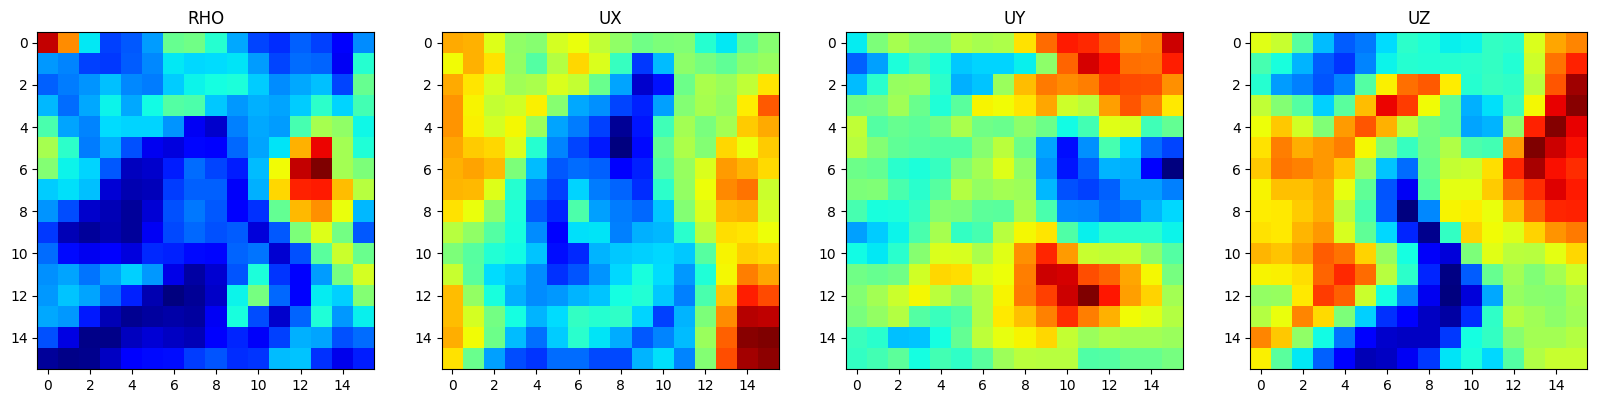

In [41]:
idx = np.random.choice(range(len(train_df)))
print(f"Index:{idx}")
data_path = input_path + "flowfields/HR/train"
RHO_filename = train_df['rho_filename'][idx]
UX_filename = train_df['ux_filename'][idx]
UY_filename = train_df['uy_filename'][idx]
UZ_filename = train_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(128, 128), cmap='jet')
axs[0].set_title('Density')
axs[1].imshow(UX.reshape(128, 128), cmap='jet')
axs[1].set_title('X-Velocity')
axs[2].imshow(UY.reshape(128, 128), cmap='jet')
axs[2].set_title('Y-Velocity')
axs[3].imshow(UZ.reshape(128, 128), cmap='jet')
axs[3].set_title('Z-Velocity')
plt.show()

HR_X = np.concatenate([RHO.reshape(128, 128, 1), UX.reshape(128, 128, 1),
                       UY.reshape(128, 128, 1), UZ.reshape(128, 128, 1)], axis=-1)

# plot LR features

data_path = input_path + "flowfields/LR/train"
RHO_filename = train_df['rho_filename'][idx]
UX_filename = train_df['ux_filename'][idx]
UY_filename = train_df['uy_filename'][idx]
UZ_filename = train_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

LR_X = np.concatenate([RHO.reshape(16, 16, 1), UX.reshape(16, 16, 1),
                       UY.reshape(16, 16, 1), UZ.reshape(16, 16, 1)], axis=-1)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(16, 16), cmap='jet')
axs[0].set_title('RHO')
axs[1].imshow(UX.reshape(16, 16), cmap='jet')
axs[1].set_title('UX')
axs[2].imshow(UY.reshape(16, 16), cmap='jet')
axs[2].set_title('UY')
axs[3].imshow(UZ.reshape(16, 16), cmap='jet')
axs[3].set_title('UZ')
plt.show()

# Setup PyTorch dataset and dataloaders:

In [42]:
class FlowFieldDataset(Dataset):
    def __init__(self, input_path, mode):
        assert mode in ["train", "val", "test"]
        self.mode = mode
        self.csv_file = pd.read_csv(input_path + f"{mode}.csv")
        if mode == "test":
            self.csv_file = pd.read_csv(input_path + f"{mode}.csv")
        self.LR_path = input_path + "flowfields/LR/" + mode
        self.HR_path = input_path + "flowfields/HR/" + mode

        self.mean = np.array([0.24, 28.0, 28.0, 28.0])
        self.std = np.array([0.068, 48.0, 48.0, 48.0])

    def transform(self, x):
        return Compose([ToTensor(), Normalize(self.mean, self.std, inplace=True)])(x)

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        # input
        if self.mode == "test":
            id = self.csv_file["id"][idx]
            rho_i = np.fromfile(self.LR_path + "/" + self.csv_file["rho_filename"][idx], dtype="<f4").reshape(16, 16)
            ux_i = np.fromfile(self.LR_path + "/" + self.csv_file["ux_filename"][idx], dtype="<f4").reshape(16, 16)
            uy_i = np.fromfile(self.LR_path + "/" + self.csv_file["uy_filename"][idx], dtype="<f4").reshape(16, 16)
            uz_i = np.fromfile(self.LR_path + "/" + self.csv_file["uz_filename"][idx], dtype="<f4").reshape(16, 16)
            X = np.stack([rho_i, ux_i, uy_i, uz_i], axis=2)
            return id, self.transform(X)

        rho_i = np.fromfile(self.LR_path + "/" + self.csv_file["rho_filename"][idx], dtype="<f4").reshape(16, 16)
        ux_i = np.fromfile(self.LR_path + "/" + self.csv_file["ux_filename"][idx], dtype="<f4").reshape(16, 16)
        uy_i = np.fromfile(self.LR_path + "/" + self.csv_file["uy_filename"][idx], dtype="<f4").reshape(16, 16)
        uz_i = np.fromfile(self.LR_path + "/" + self.csv_file["uz_filename"][idx], dtype="<f4").reshape(16, 16)
        # output
        rho_o = np.fromfile(self.HR_path + "/" + self.csv_file["rho_filename"][idx], dtype="<f4").reshape(128, 128)
        ux_o = np.fromfile(self.HR_path + "/" + self.csv_file["ux_filename"][idx], dtype="<f4").reshape(128, 128)
        uy_o = np.fromfile(self.HR_path + "/" + self.csv_file["uy_filename"][idx], dtype="<f4").reshape(128, 128)
        uz_o = np.fromfile(self.HR_path + "/" + self.csv_file["uz_filename"][idx], dtype="<f4").reshape(128, 128)
        X = np.stack([rho_i, ux_i, uy_i, uz_i], axis=2)
        Y = np.stack([rho_o, ux_o, uy_o, uz_o], axis=2)
        return self.transform(X), self.transform(Y)


In [43]:
num_filters = 64*4
num_of_residual_blocks = 16
batch_size = 256

train_dataset = FlowFieldDataset(input_path=input_path, mode="train")
val_dataset = FlowFieldDataset(input_path=input_path, mode="val")
test_dataset = FlowFieldDataset(input_path=input_path, mode="test")
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, pin_memory=False)

# Setup model:

In [44]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, num_filters, kernel_size=3):
        super(ResNetBlock, self).__init__()
        self.resnet_block = torch.nn.Sequential(
            *[
                nn.Conv2d(num_filters, num_filters, kernel_size, padding="same"),
                nn.Conv2d(num_filters, num_filters, kernel_size, padding="same"),
                nn.Conv2d(num_filters, num_filters, kernel_size, padding="same"),

            ]
        )
        self.input = nn.Sequential()

    def forward(self, x):
        inp = self.input(x)
        x = self.resnet_block(x)
        return x + inp

class Model(nn.Module):
    def __init__(
        self, in_channels=4, factor=2, scale=3, num_of_residual_blocks=16, num_filters=64, kernel_size=3, **kwargs
    ):
        super().__init__()
        self.num_of_residual_blocks = num_of_residual_blocks
        self.scale = scale
        self.factor = factor
        self.in_channels = in_channels
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.res_blocks = nn.Sequential(
            *[
                ResNetBlock(
                    in_channels=in_channels,
                    num_filters=num_filters,
                    kernel_size=kernel_size,
                )
            ]
            * num_of_residual_blocks
        )
        # Upsampling (factor ** 2) ** scale times : (2**2)**3 : 16*16 -> 128 * 128
        self.upsample = nn.Sequential(
            *[
                nn.Conv2d(num_filters, num_filters * (factor**2), kernel_size, padding="same", **kwargs),
                nn.PixelShuffle(upscale_factor=factor),
            ]
            * scale
        )
        self.resnet_input = nn.Conv2d(in_channels, num_filters, 1, padding="same")
        self.output_layer = nn.Conv2d(num_filters, in_channels, 3, padding="same")
        self.resnet_out = nn.Conv2d(self.num_filters, self.num_filters, self.kernel_size, padding="same")

    def forward(self, x):
        x = self.resnet_input(x)
        x_res = self.res_blocks(x)
        x_res = self.resnet_out(x_res)
        out = x + x_res
        out = self.upsample(out)
        return self.output_layer(out)

# Setup Accelerator and checkpointing:

In [45]:
ckpt_name = f"{generate_name()}"
num_epochs = 250
learning_rate = 5e-4
hyper_parameters = {"num_epochs": num_epochs, "learning_rate":learning_rate}

config = ProjectConfiguration(project_dir=working_dir, logging_dir=log_dir+ckpt_name)

model = Model()
loss_fn = torch.nn.MSELoss()
optimizer = Adam(params=model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer=optimizer)

accelerator = Accelerator(log_with="tensorboard", project_config=config)
accelerator.init_trackers(log_dir+ckpt_name, config=hyper_parameters)
model, optimizer, train_dataloader, val_dataloader, test_dataloader, scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, test_dataloader, scheduler
)


# Register the LR scheduler
accelerator.register_for_checkpointing(scheduler)
# Save the starting state

accelerator.save_state(output_dir=checkpoint_dir+ckpt_name)

'/kaggle/working/outputs/ckpt/laughing_mendel'

# Train model:

In [46]:
progress_bar = tqdm(range(num_epochs))
loss = 0.0
val_loss = 0.0

for epoch in range(num_epochs):
    model.train()
#     progress_bar.set_description(f"train_loss is : {loss} | epoch is : {epoch-1}") 
#     progress_bar.set_description(f"val_loss is : {val_loss} | epoch is : {epoch-1}") 

    for step, batch in enumerate(train_dataloader):
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.mse_loss(outputs, targets)
        # with torch.autograd.set_detect_anomaly(True):
        optimizer.zero_grad()
        accelerator.backward(loss)
        # loss.backward(retain_graph=True)
        optimizer.step()
        progress_bar.set_description(f"epoch : {epoch} | loss : {loss.detach().cpu()})# | step is : {step}")
        progress_bar.update(1)
        accelerator.log({"epoch": epoch, "train_loss":loss.detach().cpu()}, step=step)
        
#     progress_bar.set_description(f"train_loss is : {loss.detach().cpu()} | epoch is : {epoch}") 
    scheduler.step(loss.detach().cpu())
    
    model.eval()
    for step, batch in enumerate(val_dataloader):
        inputs, targets = batch
        outputs = model(inputs)
        val_loss = F.mse_loss(outputs, targets)
        progress_bar.set_description(f"epoch : {epoch} | val_loss : {val_loss.detach().cpu()})# | step is : {step}")
        progress_bar.update(1)
        accelerator.log({"epoch": epoch, "val_loss":val_loss.detach().cpu()}, step=step)
    
#     progress_bar.set_description(f"val_loss is : {val_loss.detach().cpu()} | epoch is : {epoch}") 
accelerator.end_training()
progress_bar.close()


  0%|          | 0/100 [00:00<?, ?it/s]
epoch : 0 | loss : 1.112182855606079)# | step is : 0:   0%|          | 0/100 [00:03<?, ?it/s]
epoch : 0 | loss : 1.112182855606079)# | step is : 0:   1%|          | 1/100 [00:03<05:06,  3.10s/it]
epoch : 0 | loss : 1.0461900234222412)# | step is : 1:   1%|          | 1/100 [00:04<05:06,  3.10s/it]
epoch : 0 | loss : 1.0461900234222412)# | step is : 1:   2%|▏         | 2/100 [00:04<03:41,  2.26s/it]
epoch : 0 | loss : 0.9598245024681091)# | step is : 2:   2%|▏         | 2/100 [00:06<03:41,  2.26s/it]
epoch : 0 | loss : 0.9598245024681091)# | step is : 2:   3%|▎         | 3/100 [00:06<03:13,  1.99s/it]
epoch : 0 | loss : 1.9396498203277588)# | step is : 3:   3%|▎         | 3/100 [00:08<03:13,  1.99s/it]
epoch : 0 | loss : 1.9396498203277588)# | step is : 3:   4%|▍         | 4/100 [00:08<03:00,  1.88s/it]
epoch : 0 | loss : 0.8373194336891174)# | step is : 4:   4%|▍         | 4/100 [00:08<03:00,  1.88s/it]
epoch : 0 | loss : 0.8373194336891174)# | 

# Generate submissions:

In [47]:
progress_bar = tqdm(range(len(test_dataloader)))
predictions = {}
ids = []
for idx, batch in enumerate(test_dataloader):
    id, inputs = batch
    outputs = model(inputs)
    outputs = outputs.permute(0, 2, 3, 1)
    predictions[idx] = outputs.cpu().detach().numpy().flatten(order="C").astype(np.float32)
    ids.append(id.cpu().detach().numpy()[0])
    progress_bar.set_description(f"test prediction: {idx}")
    progress_bar.update(1)
progress_bar.close()

print("Generating predictions")
df = pd.DataFrame.from_dict(predictions).T
df["id"] = ids
# move id to first column
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
# reset index
df = df.reset_index(drop=True)
df.to_csv(f"{output_path}{ckpt_name}.csv", index=False)
accelerator.load_state(checkpoint_dir + ckpt_name)


test prediction: 172: 100%|██████████| 173/173 [00:02<00:00, 75.86it/s]


Generating predictions


In [49]:
torch.save(model, output_path + '/' + ckpt_name + '_' +'model.pt')
torch.save(model.state_dict(), output_path + '/' + ckpt_name + '_' + 'state_dict' + '_' +'model.pt')

In [ ]:
# ckpt_name = "me"

# x = output_path + ckpt_name + '/' + ckpt_name + '_' + 'state_dict' + '_' +'model.pt'

# print(x)

In [50]:
print(ckpt_name)
df.head()

laughing_mendel


,id,0,1,2,3,4,5,6,7,8,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,-657116647631363807,0.404364,0.412417,-0.309465,-0.236466,0.567026,0.610180,-0.275993,-0.317565,0.609112,...,-0.467007,-0.376896,0.519751,0.536119,-0.334480,-0.403629,0.426978,0.484023,-0.271550,-0.258236
1,7483162365939134796,0.408900,0.405235,-0.316205,-0.244601,0.571645,0.609605,-0.286573,-0.336875,0.612565,...,-0.362291,-0.342751,0.515693,0.308991,-0.249376,-0.353527,0.441079,0.285580,-0.205753,-0.214335
2,-6212758420087317096,0.422372,0.316538,-0.299637,-0.226582,0.587003,0.473334,-0.282742,-0.311484,0.632962,...,-0.451795,-0.361412,0.516616,0.543893,-0.316418,-0.387356,0.421483,0.490754,-0.263764,-0.247713
3,-1825935182480952214,-0.436818,0.572500,-0.229554,-0.316441,-0.537917,0.814492,-0.228364,-0.445633,-0.564608,...,-0.643954,-0.739581,-0.431838,1.095583,-0.530966,-0.694252,-0.324111,0.957569,-0.449770,-0.499425
4,-1859240836295259171,1.165122,-0.197502,-0.233470,-0.141094,1.561544,-0.248140,-0.220092,-0.211477,1.698937,...,-0.353912,-0.327642,0.557148,0.007365,-0.252825,-0.338961,0.506185,0.031311,-0.191884,-0.193277


In [51]:
df.shape

(173, 65537)